# Portfolio Optimization with S&P 500 historical stock data

## <a name='preamble'></a>Preamble

This code performs the following tasks:

* Retrieves a list of companies included in the S&P 500 and gathers basic information as well as historical stock price data for them.
* Calculates daily returns based on closing prices using a simple return formula.
* Saves the data to dataframes and CSV files.
* Connects to a PostgreSQL database and imports data tables.
* Conducts portfolio optimization and outputs suggested portfolio component weights considering two scenarios: risk minimization and maximization of the Sharpe ratio.
* Plots the Efficient Frontier.

This project underscores the significance of data-driven decision-making in investment strategies, leveraging historical data and mathematical models.
The code serves as a tool for investors and is intended to provide suggestions upon which they can reconsider their investment strategy.

## <a name='outline'></a>Outline

* [Import packages](#import_packages)
* [Acquire Data & Preprocessing](#preprocessing)
    * [Download data](#download_data)
    * [Calculate daily returns](#returns)
    * [Fundamental stock information](#fundamental)
* [Connect to PostgreSQL](#potgreSQL)
    * [Connect to database](#connect)
    * [Export data](#export)
* [Portfolio Optimization](#optimization)
    * [Minimize risk: Trust-Region Constrained Algorithm](#trust_region)
    * [Maximize Sharpe ratio](#sharpe)
    * [Efficient Frontier](#eff_frontier)
* [Conclusions](#conclusions)

## <a name="import_packages"></a>Import packages

In [1]:
# basic
import pandas as pd
import pandas_datareader as pdr
import numpy as np
import time
from functools import reduce

# for downloading data
import yfinance as yf
import datetime

# for data plotting
import matplotlib.pyplot as plt
%matplotlib inline

# for portfolio optimization
import scipy
from scipy.optimize import minimize, LinearConstraint, Bounds

# for connecting with SQL database
from sqlalchemy import create_engine
from sqlalchemy import inspect
from sqlalchemy.ext.declarative import declarative_base

## <a name='preprocessing'></a>Acquire Data & Preprocessing

### <a name='download_data'></a>Download data

In [2]:
# acquire current sp500 stock symbols
sp500 = pd.read_html("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies")

symbols = sp500[0].Symbol.to_list()  # first table, column "Symbol", convert to list
symbols[0:10]  # overview of the first ten symbols

['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ADBE', 'AMD', 'AES', 'AFL', 'A']

In [3]:
# acquire fundamental stock information 
info = [] # empty list for fundamental information

for symbol in symbols:
    inf = yf.Ticker(symbol).info
    info.append(inf)
    
info[0:1]  # overview

[{'address1': '3M Center',
  'city': 'Saint Paul',
  'state': 'MN',
  'zip': '55144-1000',
  'country': 'United States',
  'phone': '651 733 1110',
  'website': 'https://www.3m.com',
  'industry': 'Conglomerates',
  'industryKey': 'conglomerates',
  'industryDisp': 'Conglomerates',
  'sector': 'Industrials',
  'sectorKey': 'industrials',
  'sectorDisp': 'Industrials',
  'longBusinessSummary': '3M Company provides diversified technology services in the United States and internationally. The company operates through four segments: Safety and Industrial; Transportation and Electronics; Health Care; and Consumer. The Safety and Industrial segment offers industrial abrasives and finishing for metalworking applications; autobody repair solutions; closure systems for personal hygiene products, masking, and packaging materials; electrical products and materials for construction and maintenance, power distribution, and electrical original equipment manufacturers; structural adhesives and tapes;

In [4]:
# due to a spelling mistake on wiki website, portfolio optimization was disturbed later on, correction below
index1, index2 = symbols.index('BRK.B'), symbols.index('BF.B')
symbols[index1], symbols[index2] = 'BRK-B', 'BF-B'

print('Correction successful')

Correction successful


In the upcoming code block, we'll handle downloading historical prices of the stocks. We aim to obtain a single dataframe containing each stock's closing price. To achieve this, we need to define some functions first.

In [6]:
# function: download data from Yahoo Finance
def get_stock(ticker):
    try:
        yf_obj = yf.Ticker(ticker)
        data = yf_obj.history(start = start, end = stop, interval = '1d')

        # only Close price
        close_price = data['Close']

        # create dataframe with close price only
        data = pd.DataFrame(close_price)
        data = data.rename(columns = {'Close': ticker}) # rename accordingly

        return data
    except Exception as e:
        print(f'Error fetching data for {ticker}: {e}')
        return None


# function: generate dataframe for multiple indexes
def combine_stocks(tickers):
    data_frames = [] # empty list
    for ticker in tickers:
        data_frames.append(get_stock(ticker)) # refer to external function

    # lambda function: merge dataframes on 'Date' column
    df_merged = reduce(lambda left, right: pd.concat([left, right], axis=1), data_frames)

    return df_merged

In [7]:
# cancel limits in terms of columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# define time_frame
start = '2010-01-01'
stop = datetime.date.today().strftime('%Y-%m-%d')

# close price information
df_cp = combine_stocks(symbols)

df_cp.head()  # overview

,MMM,AOS,ABT,ABBV,ACN,ADBE,AMD,AES,AFL,A,APD,ABNB,AKAM,ALB,ARE,ALGN,ALLE,LNT,ALL,GOOGL,GOOG,MO,AMZN,AMCR,AEE,AAL,AEP,AXP,AIG,AMT,AWK,AMP,AME,AMGN,APH,ADI,ANSS,AON,APA,AAPL,AMAT,APTV,ACGL,ADM,ANET,AJG,AIZ,T,ATO,ADSK,ADP,AZO,AVB,AVY,AXON,BKR,BALL,BAC,BK,BBWI,BAX,BDX,BRK-B,BBY,BIO,TECH,BIIB,BLK,BX,BA,BKNG,BWA,BXP,BSX,BMY,AVGO,BR,BRO,BF-B,BLDR,BG,CDNS,CZR,CPT,CPB,COF,CAH,KMX,CCL,CARR,CTLT,CAT,CBOE,CBRE,CDW,CE,COR,CNC,CNP,CF,CHRW,CRL,SCHW,CHTR,CVX,CMG,CB,CHD,CI,CINF,CTAS,CSCO,C,CFG,CLX,CME,CMS,KO,CTSH,CL,CMCSA,CMA,CAG,COP,ED,STZ,CEG,COO,CPRT,GLW,CTVA,CSGP,COST,CTRA,CCI,CSX,CMI,CVS,DHR,DRI,DVA,DAY,DE,DAL,XRAY,DVN,DXCM,FANG,DLR,DFS,DG,DLTR,D,DPZ,DOV,DOW,DHI,DTE,DUK,DD,EMN,ETN,EBAY,ECL,EIX,EW,EA,ELV,LLY,EMR,ENPH,ETR,EOG,EPAM,EQT,EFX,EQIX,EQR,ESS,EL,ETSY,EG,EVRG,ES,EXC,EXPE,EXPD,EXR,XOM,FFIV,FDS,FICO,FAST,FRT,FDX,FIS,FITB,FSLR,FE,FI,FLT,FMC,F,FTNT,FTV,FOXA,FOX,BEN,FCX,GRMN,IT,GEHC,GEN,GNRC,GD,GE,GIS,GM,GPC,GILD,GPN,GL,GS,HAL,HIG,HAS,HCA,DOC,HSIC,HSY,HES,HPE,HLT,HOLX,HD,HON,HRL,HST,HWM,HPQ,HUBB,HUM,HBAN,HII,IBM,IEX,IDXX,ITW,ILMN,INCY,IR,PODD,INTC,ICE,IFF,IP,IPG,INTU,ISRG,IVZ,INVH,IQV,IRM,JBHT,JBL,JKHY,J,JNJ,JCI,JPM,JNPR,K,KVUE,KDP,KEY,KEYS,KMB,KIM,KMI,KLAC,KHC,KR,LHX,LH,LRCX,LW,LVS,LDOS,LEN,LIN,LYV,LKQ,LMT,L,LOW,LULU,LYB,MTB,MRO,MPC,MKTX,MAR,MMC,MLM,MAS,MA,MTCH,MKC,MCD,MCK,MDT,MRK,META,MET,MTD,MGM,MCHP,MU,MSFT,MAA,MRNA,MHK,MOH,TAP,MDLZ,MPWR,MNST,MCO,MS,MOS,MSI,MSCI,NDAQ,NTAP,NFLX,NEM,NWSA,NWS,NEE,NKE,NI,NDSN,NSC,NTRS,NOC,NCLH,NRG,NUE,NVDA,NVR,NXPI,ORLY,OXY,ODFL,OMC,ON,OKE,ORCL,OTIS,PCAR,PKG,PANW,PARA,PH,PAYX,PAYC,PYPL,PNR,PEP,PFE,PCG,PM,PSX,PNW,PXD,PNC,POOL,PPG,PPL,PFG,PG,PGR,PLD,PRU,PEG,PTC,PSA,PHM,QRVO,PWR,QCOM,DGX,RL,RJF,RTX,O,REG,REGN,RF,RSG,RMD,RVTY,RHI,ROK,ROL,ROP,ROST,RCL,SPGI,CRM,SBAC,SLB,STX,SRE,NOW,SHW,SPG,SWKS,SJM,SNA,SO,LUV,SWK,SBUX,STT,STLD,STE,SYK,SYF,SNPS,SYY,TMUS,TROW,TTWO,TPR,TRGP,TGT,TEL,TDY,TFX,TER,TSLA,TXN,TXT,TMO,TJX,TSCO,TT,TDG,TRV,TRMB,TFC,TYL,TSN,USB,UBER,UDR,ULTA,UNP,UAL,UPS,URI,UNH,UHS,VLO,VTR,VLTO,VRSN,VRSK,VZ,VRTX,VFC,VTRS,VICI,V,VMC,WRB,WAB,WBA,WMT,DIS,WBD,WM,WAT,WEC,WFC,WELL,WST,WDC,WRK,WY,WHR,WMB,WTW,GWW,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2010-01-04 00:00:00-05:00,53.295387,6.009510,19.046152,NaN,32.337189,37.090000,9.70,9.656013,16.741713,20.154919,54.210285,NaN,25.920000,31.343653,41.294746,18.50,NaN,9.247096,21.949129,15.684434,15.610239,8.616377,6.6950,NaN,16.507948,4.496877,20.083548,33.192955,19.599421,34.006088,16.353594,29.150862,15.645658,41.493412,10.243714,22.530380,44.639999,32.523861,84.282051,6.470741,11.205503,NaN,7.994444,21.800150,NaN,15.202727,22.654463,7.448247,19.437899,25.670000,26.725893,158.029999,51.544674,26.843765,4.65,21.591341,11.511000,12.678569,20.468945,7.316111,24.055119,60.410358,66.220001,26.134958,97.870003,14.800172,53.639999,164.417740,6.622601,43.777542,223.388351,12.755478,40.836113,9.01,16.208229,13.586246,16.866629,7.657356,11.245727,3.77,46.219173,6.12,NaN,24.250843,22.122118,31.389763,22.306038,23.980000,23.892750,NaN,NaN,40.336723,NaN,13.82,NaN,26.229132,21.609669,5.4250,8.388148,13.426343,42.591286,33.570000,16.512785,NaN,44.988235,87.839996,36.355751,12.452536,34.174995,16.337904,21.439054,16.880301,26.639051,NaN,40.627022,38.655064,9.841436,18.498020,21.338360,29.559513,6.396005,20.770514,11.506351,24.255793,25.797638,14.327156,NaN,9.377275,2.275625,13.807094,NaN,4.225,42.566841,8.852774,27.340094,4.212119,33.340374,24.237234,23.830688,19.964403,29.959999,NaN,42.471050,9.893937,31.752357,52.174446,2.1400,NaN,28.294470,11.240437,20.905285,16.056667,21.689541,7.13

In [8]:
# save to csv file
df_cp.to_csv("close_price_SP500.csv", index = True)

### <a name='returns'></a>Calculate daily returns

In the subsequent section, we'll handle calculating daily returns according to simple formula: Daily Return (t) = Price (t) / Price (t-1) - 1

In [9]:
# generate empty dataframe
df_dr = df_cp.copy()
for i in symbols:
    df_dr[i] = None
    
# daily returns
for j in range(1, df_cp.shape[0]):  # iterate through rows
    for i in range(len(symbols)):  # iterate through columns
        prev_val = df_cp.iloc[j-1, i]  # Price (t-1)
        val = df_cp.iloc[j, i]  # Price (t)
        dr = val / prev_val - 1  # Daily Return (t)
        df_dr.iloc[j, i] = dr 

df_dr = df_dr.iloc[1:len(df_dr.index),:]  # remove the first row (NaN value only)

df_dr.head()  # overview

,MMM,AOS,ABT,ABBV,ACN,ADBE,AMD,AES,AFL,A,APD,ABNB,AKAM,ALB,ARE,ALGN,ALLE,LNT,ALL,GOOGL,GOOG,MO,AMZN,AMCR,AEE,AAL,AEP,AXP,AIG,AMT,AWK,AMP,AME,AMGN,APH,ADI,ANSS,AON,APA,AAPL,AMAT,APTV,ACGL,ADM,ANET,AJG,AIZ,T,ATO,ADSK,ADP,AZO,AVB,AVY,AXON,BKR,BALL,BAC,BK,BBWI,BAX,BDX,BRK-B,BBY,BIO,TECH,BIIB,BLK,BX,BA,BKNG,BWA,BXP,BSX,BMY,AVGO,BR,BRO,BF-B,BLDR,BG,CDNS,CZR,CPT,CPB,COF,CAH,KMX,CCL,CARR,CTLT,CAT,CBOE,CBRE,CDW,CE,COR,CNC,CNP,CF,CHRW,CRL,SCHW,CHTR,CVX,CMG,CB,CHD,CI,CINF,CTAS,CSCO,C,CFG,CLX,CME,CMS,KO,CTSH,CL,CMCSA,CMA,CAG,COP,ED,STZ,CEG,COO,CPRT,GLW,CTVA,CSGP,COST,CTRA,CCI,CSX,CMI,CVS,DHR,DRI,DVA,DAY,DE,DAL,XRAY,DVN,DXCM,FANG,DLR,DFS,DG,DLTR,D,DPZ,DOV,DOW,DHI,DTE,DUK,DD,EMN,ETN,EBAY,ECL,EIX,EW,EA,ELV,LLY,EMR,ENPH,ETR,EOG,EPAM,EQT,EFX,EQIX,EQR,ESS,EL,ETSY,EG,EVRG,ES,EXC,EXPE,EXPD,EXR,XOM,FFIV,FDS,FICO,FAST,FRT,FDX,FIS,FITB,FSLR,FE,FI,FLT,FMC,F,FTNT,FTV,FOXA,FOX,BEN,FCX,GRMN,IT,GEHC,GEN,GNRC,GD,GE,GIS,GM,GPC,GILD,GPN,GL,GS,HAL,HIG,HAS,HCA,DOC,HSIC,HSY,HES,HPE,HLT,HOLX,HD,HON,HRL,HST,HWM,HPQ,HUBB,HUM,HBAN,HII,IBM,IEX,IDXX,ITW,ILMN,INCY,IR,PODD,INTC,ICE,IFF,IP,IPG,INTU,ISRG,IVZ,INVH,IQV,IRM,JBHT,JBL,JKHY,J,JNJ,JCI,JPM,JNPR,K,KVUE,KDP,KEY,KEYS,KMB,KIM,KMI,KLAC,KHC,KR,LHX,LH,LRCX,LW,LVS,LDOS,LEN,LIN,LYV,LKQ,LMT,L,LOW,LULU,LYB,MTB,MRO,MPC,MKTX,MAR,MMC,MLM,MAS,MA,MTCH,MKC,MCD,MCK,MDT,MRK,META,MET,MTD,MGM,MCHP,MU,MSFT,MAA,MRNA,MHK,MOH,TAP,MDLZ,MPWR,MNST,MCO,MS,MOS,MSI,MSCI,NDAQ,NTAP,NFLX,NEM,NWSA,NWS,NEE,NKE,NI,NDSN,NSC,NTRS,NOC,NCLH,NRG,NUE,NVDA,NVR,NXPI,ORLY,OXY,ODFL,OMC,ON,OKE,ORCL,OTIS,PCAR,PKG,PANW,PARA,PH,PAYX,PAYC,PYPL,PNR,PEP,PFE,PCG,PM,PSX,PNW,PXD,PNC,POOL,PPG,PPL,PFG,PG,PGR,PLD,PRU,PEG,PTC,PSA,PHM,QRVO,PWR,QCOM,DGX,RL,RJF,RTX,O,REG,REGN,RF,RSG,RMD,RVTY,RHI,ROK,ROL,ROP,ROST,RCL,SPGI,CRM,SBAC,SLB,STX,SRE,NOW,SHW,SPG,SWKS,SJM,SNA,SO,LUV,SWK,SBUX,STT,STLD,STE,SYK,SYF,SNPS,SYY,TMUS,TROW,TTWO,TPR,TRGP,TGT,TEL,TDY,TFX,TER,TSLA,TXN,TXT,TMO,TJX,TSCO,TT,TDG,TRV,TRMB,TFC,TYL,TSN,USB,UBER,UDR,ULTA,UNP,UAL,UPS,URI,UNH,UHS,VLO,VTR,VLTO,VRSN,VRSK,VZ,VRTX,VFC,VTRS,VICI,V,VMC,WRB,WAB,WBA,WMT,DIS,WBD,WM,WAT,WEC,WFC,WELL,WST,WDC,WRK,WY,WHR,WMB,WTW,GWW,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2010-01-05 00:00:00-05:00,-0.006263,-0.012777,-0.008079,NaN,0.00618,0.016446,0.001031,-0.010241,0.02901,-0.010863,-0.008297,NaN,0.029707,-0.001838,-0.010543,-0.026486,NaN,0.023394,0.016442,-0.004404,-0.004404,0.000505,0.0059,NaN,-0.003962,0.113207,-0.011448,-0.002199,-0.018735,0.016567,0.010155,0.02332,-0.004404,-0.008662,-0.020897,-0.001579,-0.022401,-0.006325,0.011807,0.001729,-0.007692,NaN,-0.003336,0.005402,NaN,-0.005374,0.029841,-0.004899,-0.010502,-0.015193,-0.00537,-0.008353,-0.007512,0.006513,0.010753,0.058681,-0.01124,0.032505,0.010604,-0.032626,-0.006863,-0.009288,0.004832,0.025379,0.017472,-0.00859,-0.004847,0.004317,0.005835,0.032752,0.011609,0.047662,0.015201,0.00333,-0.015606,0.007423,-0.003966,-0.007218,-0.010409,-0.047745,0.034494,-0.009804,NaN,-0.002169,0.001771,0.039437,-0.008914,0.005838,0.009669,NaN,NaN,0.011955,NaN,0.023878,NaN,0.022249,-0.007135,-0.031797,-0.007576,0.016224,-0.020728,0.00566,-0.003033,NaN,0.007084,0.013434,-0.022529,-0.013531,0.016772,0.000377,-0.001516,-0.004455,0.038235,NaN,0.010906,-0.000817,-0.003166,-0.012097,0.011325,0.008087,-0.013553,0.003606,0.004327,0.000951,-0.013001,-0.012407,NaN,0.011655,-0.000275,0.003579,NaN,0.004734,-0.00303,-0.001298,0.009594,0.026401,0.023647,-0.003942,-0.001198,-0.004286,-0.008511,NaN,-0.003746,0.078432,-0.011888,0.001045,0.015187,NaN,0.00658,0.033539,0.007799,-0.012664,-0.01232,0.009217,-0.004721,Na

In [10]:
# save to csv file
df_dr.to_csv("daily_returns_SP500.csv", index = True)

### <a name='fundamental'></a>Fundamental stock information

Turning our attention back to fundamental stock information, let's generate another dataframe containing all relevant data.

In [11]:
df_fund = pd.DataFrame(info)  # create a dataframe of fundamental information about each ticker
df_fund = df_fund.drop(['longBusinessSummary', 'companyOfficers'], axis = 1)  # drop dict dtype --- postgresql cannot take it

df_fund.head()  # overview

,address1,city,state,zip,country,phone,website,industry,industryKey,industryDisp,sector,sectorKey,sectorDisp,fullTimeEmployees,auditRisk,boardRisk,compensationRisk,shareHolderRightsRisk,overallRisk,governanceEpochDate,compensationAsOfEpochDate,maxAge,priceHint,previousClose,open,dayLow,dayHigh,regularMarketPreviousClose,regularMarketOpen,regularMarketDayLow,regularMarketDayHigh,dividendRate,dividendYield,exDividendDate,payoutRatio,fiveYearAvgDividendYield,beta,forwardPE,volume,regularMarketVolume,averageVolume,averageVolume10days,averageDailyVolume10Day,bid,bidSize,askSize,marketCap,fiftyTwoWeekLow,fiftyTwoWeekHigh,priceToSalesTrailing12Months,fiftyDayAverage,twoHundredDayAverage,trailingAnnualDividendRate,trailingAnnualDividendYield,currency,enterpriseValue,profitMargins,floatShares,sharesOutstanding,sharesShort,sharesShortPriorMonth,sharesShortPreviousMonthDate,dateShortInterest,sharesPercentSharesOut,heldPercentInsiders,heldPercentInstitutions,shortRatio,shortPercentOfFloat,impliedSharesOutstanding,bookValue,priceToBook,lastFiscalYearEnd,nextFiscalYearEnd,mostRecentQuarter,earningsQuarterlyGrowth,netIncomeToCommon,trailingEps,forwardEps,pegRatio,lastSplitFactor,lastSplitDate,enterpriseToRevenue,enterpriseToEbitda,52WeekChange,SandP52WeekChange,lastDividendValue,lastDividendDate,exchange,quoteType,symbol,underlyingSymbol,shortName,longName,firstTradeDateEpochUtc,timeZoneFullName,timeZoneShortName,uuid,messageBoardId,gmtOffSetMilliseconds,currentPrice,targetHighPrice,targetLowPrice,targetMeanPrice,targetMedianPrice,recommendationMean,recommendationKey,numberOfAnalystOpinions,totalCash,totalCashPerShare,ebitda,totalDebt,quickRatio,currentRatio,totalRevenue,debtToEquity,revenuePerShare,returnOnAssets,returnOnEquity,freeCashflow,operatingCashflow,earningsGrowth,revenueGrowth,grossMargins,ebitdaMargins,operatingMargins,financialCurrency,trailingPegRatio,address2,trailingPE,ask,fax,industrySymbol
0,3M Center,Saint Paul,MN,55144-1000,United States,651 733 1110,https://www.3m.com,Conglomerates,conglomerates,Conglomerates,Industrials,industrials,Industrials,85000.0,4.0,8.0,7.0,4.0,6.0,1.709251e+09,1.672445e+09,86400,2.0,92.62,93.49,93.180,94.7400,92.62,93.49,93.180,94.7400,6.04,0.0643,1.707955e+09,0.6167,4.18,1.000,9.205883,4118618.0,4118618.0,4190720.0,3730970.0,3730970.0,93.68,900.0,800.0,5.189853e+10,85.35,113.14,1.588034,98.4190,99.00275,6.00,0.064781,USD,6.291553e+10,-0.21404,5.517549e+08,5.527000e+08,6075186.0,7033985.0,1.705018e+09,1.707955e+09,0.0110,0.00115,0.66889,1.16,0.0110,5.552390e+08,8.699,10.794344,1.703981e+09,1.735603e+09,1.703981e+09,0.747,-6.995000e+09,-12.63,10.20,2.36,2:1,1.064880e+09,1.925,7.993,-0.092754,0.32884,1.51,1.707955e+09,NYQ,EQUITY,MMM,MMM,3M Company,3M Company,-2.523222e+08,America/New_York,EDT,375388b3-dab7-3763-90cd-457ad19388a2,finmb_289194,-14400000.0,93.90,111.57,84.0,103.77,105.0,3.1,hold,13.0,5.986000e+09,10.830,7.871000e+09,1.694200e+10,0.709,1.071,3.268100e+10,348.028,59.002,0.07580,-0.71076,8.937750e+09,6.680000e+09,0.744,-0.008,0.43772,0.24084,0.12642,USD,2.1478,NaN,NaN,NaN,NaN,NaN
1,11270 West Park Place,Milwaukee,WI,53224-9508,United States,414 359 4000,https://www.aosmith.com,Specialty Industrial Machinery,specialty-industrial-machinery,Specialty Industrial Machinery,Industrials,industrials,Industrials,12000.0,2.0,10.0,7.0,10.0,10.0,1.709251e+09,1.703981e+09,86400,2.0,86.65,87.04,85.660,87.6000,86.65,87.04,85.660,87.6000,1.28,0.0149,1.706573e+09,0.3306,1.77,1.238,19.819862,627436.0,627436.0,940736.0,919570.0,919570.0,75.88,800.0,800.0,1.262095e+10,63.40,87.60,3.275786,81.0604,73.94065,1.22,0.014080,USD,1.243568e+10,0.14447,1.190249e+08,1.211760e+08,2969525.0,2264246.0,1.705018e+09,1.707955e+09,0.0202,0.00833,0.97575,2.86,0.0247,1.471950e+08,12.502,6.864502,1.703981e+09,1.735603e+09,1.703981e+09,NaN,5.566000e+08,3.69,4.33,2.67,2:1,1.475712e+09,3.228,15.180,0.304652,0.32884,0.32,1.706573e+09,NYQ,EQUITY,AOS,AOS,A.O. Smith Corporation,A. O. Smith Corporation,4.337766e+08,America/New_York,ED

Recalling past confusion with spelling, we'll ensure our data is coherent between dataframes by correcting it again.

In [12]:
# find the index of the known value 'BRK.B' in the 'symbol' column
index3 = df_fund.loc[df_fund['symbol'] == 'BRK.B'].index[0]

# replace value
df_fund.loc[index3, ['symbol', 'underlyingSymbol']] = ['BRK-B', 'BRK-B']

In [13]:
# find the index of the known value 'BF.B' in the 'symbol' column
index4 = df_fund.loc[df_fund['symbol'] == 'BF.B'].index[0]

# replace value
df_fund.loc[index4, ['symbol', 'underlyingSymbol']] = ['BF-B', 'BF-B']

As stock symbols are listed at different moments in time, tickers that have been listed after the start of our declared timeframe will have NaN values. This may cause problems with portfolio optimization in the next section. To avoid errors, let's assume that the newest symbols will be removed from our dataframe.

In [14]:
# check for missing values
null_val_sums = df_cp.isnull().sum()
df_mv = pd.DataFrame({"Column": null_val_sums.index, "Number of Null/Missing Values": null_val_sums.values,
              "Proportion/Count": null_val_sums.values / len(df_cp), "Data Type": df_cp.dtypes })

df_mv.head()  # missing values information

,Column,Number of Null/Missing Values,Proportion/Count,Data Type
MMM,MMM,0,0.000000,float64
AOS,AOS,0,0.000000,float64
ABT,ABT,0,0.000000,float64
ABBV,ABBV,754,0.211264,float64
ACN,ACN,0,0.000000,float64


In [15]:
# filter DataFrame to show only rows with number of null > 0
df_mv_NaN = df_mv[df_mv["Number of Null/Missing Values"] > 0]

df_mv_NaN  # overview

,Column,Number of Null/Missing Values,Proportion/Count,Data Type
ABBV,ABBV,754,0.211264,float64
ABNB,ABNB,2754,0.771645,float64
ALLE,ALLE,976,0.273466,float64
AMCR,AMCR,596,0.166994,float64
APTV,APTV,474,0.132810,float64
ANET,ANET,1113,0.311852,float64
CZR,CZR,1187,0.332586,float64
CARR,CARR,2569,0.719809,float64
CTLT,CTLT,1151,0.322499,float64
CBOE,CBOE,112,0.031381,float64


In [16]:
columns_names_to_delete = []

for i in range(df_mv_NaN.shape[0]):
    column_name = df_mv_NaN.iloc[i, 0]
    columns_names_to_delete.append(column_name)

columns_names_to_delete  # overview

['ABBV',
 'ABNB',
 'ALLE',
 'AMCR',
 'APTV',
 'ANET',
 'CZR',
 'CARR',
 'CTLT',
 'CBOE',
 'CDW',
 'CHTR',
 'CFG',
 'CEG',
 'CTVA',
 'DAY',
 'FANG',
 'DOW',
 'ENPH',
 'EPAM',
 'ETSY',
 'FLT',
 'FTV',
 'FOXA',
 'FOX',
 'GEHC',
 'GNRC',
 'GM',
 'HCA',
 'HPE',
 'HLT',
 'HWM',
 'HII',
 'IR',
 'INVH',
 'IQV',
 'KVUE',
 'KEYS',
 'KMI',
 'KHC',
 'LW',
 'LYB',
 'MPC',
 'META',
 'MRNA',
 'NWSA',
 'NWS',
 'NCLH',
 'NXPI',
 'OTIS',
 'PANW',
 'PAYC',
 'PYPL',
 'PSX',
 'QRVO',
 'NOW',
 'SYF',
 'TRGP',
 'TSLA',
 'UBER',
 'VLTO',
 'VICI',
 'WRK',
 'XYL',
 'ZTS']

In [17]:
# drop columns
df_cp = df_cp.drop(columns=columns_names_to_delete)
df_dr = df_dr.drop(columns=columns_names_to_delete)

Since we've made some changes to our dataframes, let's update the CSV files.

In [18]:
# save updated data to csv file
df_cp.to_csv("close_price_SP500.csv", index = True)
df_dr.to_csv("daily_returns_SP500.csv", index = True)

## <a name='potgreSQL'></a>Connect to PostgreSQL

Now, let's explore the functionality of the SQLAlchemy package for exporting acquired data to an SQL database.

*Censored for repository.*

### <a name='connection'></a>Connect to dabase

In [42]:
# database credentials
# db_name = '###'
# db_user = '###'
# db_password = '###'
# db_host = '###'
# db_port = '###'

# create the SQLAlchemy engine 
# connection_string = f'postgresql://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}'
# engine = create_engine(connection_string)

# confirm that the engine was created successfully
# print("SQLAlchemy engine created successfully!")

### <a name='export'></a>Export data

In [44]:
# save fundamentals dataframe to sql database
# df_fund.to_sql("Fundamentals", engine, index = False, if_exists = 'replace')

# save dataframe with stocks close price to sql database
# df_cp.to_sql("ClosePrice", engine, index = True, if_exists = 'replace')

# save daily returns to sql database
# df_dr.to_sql("DailyReturns", engine, index = True, if_exists = 'replace')

In [21]:
# optional: pd.read_sql("Fundamentals", engine) etc.

## <a name='optimization'></a>Portfolio Optimization

Turning our focus to portfolio optimization, we'll consider two methods. The first, known as the Trust-Region Constrained Algorithm, focuses on risk minimization and is ideal for investors who are risk-averse and prefer a safer approach. The second, based on the efficient frontier, aims to maximize the Sharpe ratio, making it more suitable for investors seeking the most effective mix for their portfolio. 
In both cases, the primary goal is to obtain a weighted set of stocks that will serve as a suggestion for an investment strategy.

### <a name='trust_region'></a>Minimize risk: Trust-Region Constrained Algorithm

In [22]:
# calculate average annual return for each stock (*252)
avg_annual_return = np.mean(df_dr, axis=0) * 252

# covariance matrix
cov_matrix = df_dr.cov()

# number of assets
num_assets = df_dr.shape[1]

# define constraints
# wages must be in range 0 - 1
bounds = Bounds(0, 1)

# wages must sum up to 1
constraint_matrix = np.ones((1, num_assets))  # numpy.ones() creates new numeric table filled with ones
linear_constraint = LinearConstraint(constraint_matrix, [1], [1])

In [23]:
# function: define risk of portfolio
def portfolio_volatility(weights):
    return np.sqrt(np.dot(weights, np.dot(weights, cov_matrix)))

# function: defines overall rate of return for the whole portfolio -- SIGMA Ri * wi -- refers to the wages of the given assets
def ret(avg_annual_return, w):
    return avg_annual_return.dot(w) 

In [24]:
# find portfolio with minimal risk
# initial distributial of wages (equally distributed)
initial_weights = np.ones(num_assets) / num_assets

# minimize risk with 'trust-constr' method
res = minimize(portfolio_volatility, initial_weights, method='trust-constr', constraints=linear_constraint, bounds=bounds)

# wages for porfolio with lowest risk possible
w_min = res.x

# wages and risks should be shown with two decimal places
np.set_printoptions(suppress=True, precision=2)

# results
print("Optimal weights for minimum risk portfolio:")
print(w_min)
print("Rate of raturn: %.2f%%" % (ret(avg_annual_return, w_min) * 100), "Risk: %.3f" % portfolio_volatility(w_min))

Optimal weights for minimum risk portfolio:
[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.02 0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.03 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.01
 0.   0.   0.   0.01 0.   0.   0.   0.   0.   0.   0.   0.   0.04 0.
 0.   0.   0.   0.   0.   0.   0.   0.02 0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.03 0.   0.   0.   0.02 0.   0.   0.   0.
 0.   0.   0.   0.06 0.   0.   0.01 0.   0.   0.   0.   0.   0.   0.05
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.01
 0.   0.   0.   0.   0.   0.   0.   0.01 0.   0.   0.01 0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.01 0.   0.   0.02 0.   0.   0.

In [25]:
# let assume that our hipothetical inwestor considers a portfolio that minimizes risk 
chosen_trca = [] 
col_chosen_trca = []

threshold = 0.01 # minimum wage considered for the asset to be included in the portfolio

for i in range(len(w_min)):
    pair = []
    if w_min[i] >= threshold:
        pair.append(df_cp.columns[i])
        pair.append(w_min[i].round(2))
        chosen_trca.append(pair)
        col_chosen_trca.append(df_cp.columns[i])

print('Chosen set of stock that minimizes risk: \n')
for x, y in chosen_trca:
    print('Stock index: {0}  \t weight: {1}'.format(x, y))

Chosen set of stock that minimizes risk: 

Stock index: MO  	 weight: 0.02
Stock index: AZO  	 weight: 0.03
Stock index: TECH  	 weight: 0.01
Stock index: BMY  	 weight: 0.04
Stock index: CPB  	 weight: 0.02
Stock index: CHRW  	 weight: 0.03
Stock index: CMG  	 weight: 0.02
Stock index: CLX  	 weight: 0.06
Stock index: ED  	 weight: 0.05
Stock index: DVA  	 weight: 0.01
Stock index: DPZ  	 weight: 0.01
Stock index: GEN  	 weight: 0.01
Stock index: GIS  	 weight: 0.02
Stock index: JNJ  	 weight: 0.1
Stock index: K  	 weight: 0.05
Stock index: KDP  	 weight: 0.05
Stock index: KR  	 weight: 0.03
Stock index: LMT  	 weight: 0.02
Stock index: MCD  	 weight: 0.08
Stock index: NEM  	 weight: 0.04
Stock index: DGX  	 weight: 0.01
Stock index: SJM  	 weight: 0.02
Stock index: VZ  	 weight: 0.1
Stock index: WMT  	 weight: 0.09
Stock index: WTW  	 weight: 0.01


In [26]:
# create a separate dataframe of close price for the chosen set of stock
df_cp_chosen_trca = df_cp.copy()
df_cp_chosen_trca = df_cp_chosen_trca[col_chosen_trca]

df_cp_chosen_trca.head()  # overview

,MO,AZO,TECH,BMY,CPB,CHRW,CMG,CLX,ED,DVA,DPZ,GEN,GIS,JNJ,K,KDP,KR,LMT,MCD,NEM,DGX,SJM,VZ,WMT,WTW
Date,,,,,,,,,,,,,,,,,,,,,,,,,
2010-01-04 00:00:00-05:00,8.616377,158.029999,14.800172,16.208229,22.122118,42.591286,87.839996,40.627022,25.797638,29.959999,7.131133,6.823841,22.238554,42.650616,31.083654,3.305809,7.856655,49.061691,42.268993,35.390480,47.354362,42.548306,15.417355,13.241261,53.053867
2010-01-05 00:00:00-05:00,8.620729,156.710007,14.673036,15.955279,22.161301,41.708458,89.019997,41.070114,25.462234,29.705000,7.196858,6.786754,22.031540,42.156075,31.154263,3.267184,7.764586,49.572414,41.945816,35.485420,46.369427,42.349884,15.445148,13.109408,52.934978
2010-01-06 00:00:00-05:00,8.746990,155.240005,14.634248,15.948945,21.913109,41.155796,87.320000,40.964314,25.735094,29.530001,7.402248,6.809007,22.163277,42.498951,31.160143,3.339889,7.768420,48.844627,41.373512,36.237785,45.655933,42.500412,15.001040,13.080105,53.787170
2010-01-07 00:00:00-05:00,8.733927,157.300003,14.668726,15.961592,21.580000,40.761032,86.430000,40.574112,25.644152,29.785000,7.698008,6.794171,22.520184,42.195637,31.466105,3.303536,7.845150,47.503971,41.676502,36.004051,46.097984,42.384087,14.911755,13.087427,53.628616
2010-01-08 00:00:00-05:00,8.755700,155.279999,14.640717,15.695991,21.442844,41.306515,91.889999,40.580715,25.723734,30.500000,7.698008,6.812716,22.336996,42.340702,31.407278,3.279680,7.772260,48.270058,41.636097,36.245094,46.097984,42.479885,14.921146,13.021504,53.569141


In [27]:
# save to csv
df_cp_chosen_trca.to_csv("close_price_chosen_trca.csv", index = True)

In [28]:
# create a separate dataframe of daily returns for the chosen set of stock
df_dr_chosen_trca = df_dr.copy()
df_dr_chosen_trca = df_dr_chosen_trca[col_chosen_trca]

df_dr_chosen_trca.head()  # overview

,MO,AZO,TECH,BMY,CPB,CHRW,CMG,CLX,ED,DVA,DPZ,GEN,GIS,JNJ,K,KDP,KR,LMT,MCD,NEM,DGX,SJM,VZ,WMT,WTW
Date,,,,,,,,,,,,,,,,,,,,,,,,,
2010-01-05 00:00:00-05:00,0.000505,-0.008353,-0.00859,-0.015606,0.001771,-0.020728,0.013434,0.010906,-0.013001,-0.008511,0.009217,-0.005435,-0.009309,-0.011595,0.002272,-0.011684,-0.011719,0.01041,-0.007646,0.002683,-0.020799,-0.004663,0.001803,-0.009958,-0.002241
2010-01-06 00:00:00-05:00,0.014646,-0.00938,-0.002643,-0.000397,-0.011199,-0.013251,-0.019097,-0.002576,0.010716,-0.005891,0.028539,0.003279,0.005979,0.008134,0.000189,0.022253,0.000494,-0.014681,-0.013644,0.021202,-0.015387,0.003554,-0.028754,-0.002235,0.016099
2010-01-07 00:00:00-05:00,-0.001493,0.01327,0.002356,0.000793,-0.015201,-0.009592,-0.010192,-0.009525,-0.003534,0.008635,0.039955,-0.002179,0.016104,-0.007137,0.009819,-0.010885,0.009877,-0.027447,0.007323,-0.00645,0.009682,-0.002737,-0.005952,0.00056,-0.002948
2010-01-08 00:00:00-05:00,0.002493,-0.012842,-0.001909,-0.01664,-0.006356,0.013382,0.063172,0.000163,0.003103,0.024005,0.0,0.002729,-0.008134,0.003438,-0.00187,-0.007221,-0.009291,0.016127,-0.000969,0.006695,0.0,0.00226,0.00063,-0.005037,-0.001109
2010-01-11 00:00:00-05:00,0.007459,0.001288,-0.006476,0.010475,0.003046,0.002954,0.053107,-0.000326,0.012596,0.012951,0.007471,-0.000544,0.00099,0.000156,0.000562,-0.006581,0.003948,0.004761,0.007762,0.011286,0.002524,-0.002255,0.004094,0.016501,0.009989


In [29]:
# save to csv
df_dr_chosen_trca.to_csv("daily_returns_chosen_trca.csv", index = True)

### <a name='sharpe'></a>Maximize Sharpe ratio

In [30]:
# function: calculate negative Sharpe Ratio (1/volatility)
def sharpe_ratio(weights):
    portfolio_volatility = np.sqrt(np.dot(weights, np.dot(weights, cov_matrix)))
    portfolio_return = np.dot(avg_annual_return, weights)
    return -portfolio_return / portfolio_volatility  # minus for minimilization purposes

In [31]:
# initial distributial of wages (equally distributed)
initial_weights = np.ones(num_assets) / num_assets

# minimize negative Sharpe Ratio with 'trust-constr' method (maximize Sharpe Ratio)
res_sharpe = minimize(sharpe_ratio, initial_weights, method='trust-constr', constraints=linear_constraint, bounds=bounds)

# wages for porfolio with highest Sharpe ratio
w_sharpe = res_sharpe.x

# results should be shown with two decimal places
np.set_printoptions(suppress=True, precision=2)

# print the optimal weights and corresponding return and risk
print("Optimal weights maximazing Sharpe ratio:")
print(w_sharpe)
print("Rate of return: %.2f%%" % (np.dot(avg_annual_return, w_sharpe) * 100), "Risk: %.3f" % np.sqrt(np.dot(w_sharpe, np.dot(w_sharpe, cov_matrix))))

Optimal weights maximazing Sharpe ratio:
[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.07 0.   0.   0.03 0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.03
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.02 0.   0.03 0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.02 0.   0.   0.   0.   0.03 0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.02 0.   0.   0.   0.   0.   0.14 0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.2  0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.04 0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  

In [32]:
# let assume that our hipothetical inwestor considers a portfolio that maximizes Sharpe Ratio
chosen_sharpe = [] 
col_chosen_sharpe = []

threshold = 0.01 # minimum wage considered for the asset to be included in the portfolio

for i in range(len(w_sharpe)):
    pair = []
    if w_sharpe[i] >= threshold:
        pair.append(df_cp.columns[i])
        pair.append(w_sharpe[i].round(2))
        chosen_sharpe.append(pair)
        col_chosen_sharpe.append(df_cp.columns[i])

print('Chosen set of stock that maximizes Sharpe ratio: \n')
for x, y in chosen_sharpe:
    print('Stock index: {0} \t weight: {1}'.format(x, y))

Chosen set of stock that maximizes Sharpe ratio: 

Stock index: AZO 	 weight: 0.07
Stock index: AXON 	 weight: 0.03
Stock index: AVGO 	 weight: 0.03
Stock index: CMG 	 weight: 0.02
Stock index: CHD 	 weight: 0.03
Stock index: STZ 	 weight: 0.02
Stock index: COST 	 weight: 0.03
Stock index: DXCM 	 weight: 0.02
Stock index: DPZ 	 weight: 0.14
Stock index: LLY 	 weight: 0.2
Stock index: EXR 	 weight: 0.04
Stock index: KDP 	 weight: 0.03
Stock index: KR 	 weight: 0.03
Stock index: NFLX 	 weight: 0.05
Stock index: NVDA 	 weight: 0.03
Stock index: ORLY 	 weight: 0.04
Stock index: ODFL 	 weight: 0.03
Stock index: PGR 	 weight: 0.05
Stock index: REGN 	 weight: 0.03
Stock index: TDG 	 weight: 0.05


In [33]:
# create a separate dataframe of close price for the chosen set of stock
df_cp_chosen_sharpe = df_cp.copy()
df_cp_chosen_sharpe = df_cp_chosen_sharpe[col_chosen_sharpe]

df_cp_chosen_sharpe.head()  # overview

,AZO,AXON,AVGO,CMG,CHD,STZ,COST,DXCM,DPZ,LLY,EXR,KDP,KR,NFLX,NVDA,ORLY,ODFL,PGR,REGN,TDG
Date,,,,,,,,,,,,,,,,,,,,
2010-01-04 00:00:00-05:00,158.029999,4.65,13.586246,87.839996,12.452536,14.327156,42.566841,2.1400,7.131133,23.776001,7.447290,3.305809,7.856655,7.640000,4.240228,38.500000,8.437675,11.289371,24.629999,23.933880
2010-01-05 00:00:00-05:00,156.710007,4.70,13.687099,89.019997,12.284039,14.149399,42.437874,2.1725,7.196858,23.357824,7.397181,3.267184,7.764586,7.358571,4.302147,38.560001,8.619160,11.251805,25.100000,24.161591
2010-01-06 00:00:00-05:00,155.240005,5.84,13.795160,87.320000,12.342911,14.336042,42.989574,2.2375,7.402248,23.530409,7.422237,3.339889,7.768420,7.617143,4.329666,38.389999,8.777604,11.139099,24.719999,24.331160
2010-01-07 00:00:00-05:00,157.300003,5.66,13.708711,86.430000,12.204867,14.193838,42.781784,2.3025,7.698008,23.410929,7.365867,3.303536,7.845150,7.485714,4.244815,38.270000,8.354134,10.988823,24.570000,24.646082
2010-01-08 00:00:00-05:00,155.279999,5.56,13.809561,91.889999,12.178477,13.918316,42.473698,2.2600,7.698008,23.231712,7.203016,3.279680,7.772260,7.614286,4.253989,37.930000,8.469360,11.089007,24.370001,24.927088


In [34]:
# save to csv
df_cp_chosen_sharpe.to_csv("close_price_chosen_sharpe.csv", index = True)

In [35]:
# create a separate dataframe of close price for the chosen set of stock
df_dr_chosen_sharpe = df_dr.copy()
df_dr_chosen_sharpe = df_dr_chosen_sharpe[col_chosen_sharpe]

df_dr_chosen_sharpe.head()  # overview

,AZO,AXON,AVGO,CMG,CHD,STZ,COST,DXCM,DPZ,LLY,EXR,KDP,KR,NFLX,NVDA,ORLY,ODFL,PGR,REGN,TDG
Date,,,,,,,,,,,,,,,,,,,,
2010-01-05 00:00:00-05:00,-0.008353,0.010753,0.007423,0.013434,-0.013531,-0.012407,-0.00303,0.015187,0.009217,-0.017588,-0.006728,-0.011684,-0.011719,-0.036836,0.014603,0.001558,0.021509,-0.003327,0.019082,0.009514
2010-01-06 00:00:00-05:00,-0.00938,0.242553,0.007895,-0.019097,0.004793,0.013191,0.013,0.029919,0.028539,0.007389,0.003387,0.022253,0.000494,0.035139,0.006396,-0.004409,0.018383,-0.010017,-0.015139,0.007018
2010-01-07 00:00:00-05:00,0.01327,-0.030822,-0.006267,-0.010192,-0.011184,-0.009919,-0.004834,0.02905,0.039955,-0.005078,-0.007595,-0.010885,0.009877,-0.017254,-0.019598,-0.003126,-0.048244,-0.013491,-0.006068,0.012943
2010-01-08 00:00:00-05:00,-0.012842,-0.017668,0.007357,0.063172,-0.002162,-0.019411,-0.007201,-0.018458,0.0,-0.007655,-0.022109,-0.007221,-0.009291,0.017176,0.002161,-0.008884,0.013793,0.009117,-0.00814,0.011402
2010-01-11 00:00:00-05:00,0.001288,0.113309,0.00626,0.053107,-0.004334,0.001916,0.001181,-0.003319,0.007471,0.013715,0.007826,-0.006581,0.003948,-0.001313,-0.014016,0.005273,-0.005782,-0.02541,0.019286,0.000194


In [45]:
# save to csv
df_dr_chosen_sharpe.to_csv("daily_returns_chosen_sharpe.csv", index = True)

### <a name='eff_frontier'></a>Efficient Frontier

It's possible our hypothetical investor is not satisfied with just two options to look at. Let's give them a tool to compare the optimal set of portfolios that are considered to be efficient. A curved line that represents a set of investment portfolios that are expected to provide the highest returns at a given level of risk is called the Efficient Frontier. 
Next, we'll work towards plotting it.

In [37]:
# begin at the point with the maximum rate of return for the minimum risk (MVP point), and then gradually increase the rate of return
num_ports = 20 # consider 20 portfolios

# store weights 
all_weights = np.zeros((num_ports, num_assets))

# calulate gap between subsequent rate of returns
gap = (np.amax(avg_annual_return) - ret(avg_annual_return, w_min)) / num_ports

# first portfolio is to represent w_min
# second portfolio is to represent w_sharpe 
all_weights[0], all_weights[1] = w_min, w_sharpe

In [38]:
# function: defines risk level
def vol(w, cov_matrix):
    return np.sqrt(np.dot(w, np.dot(w, cov_matrix)))

In [39]:
# store rates of return and risk in arrays 
ret_arr = np.zeros(num_ports)
vol_arr = np.zeros(num_ports)

# calculate rates of return and risks for w_min and w_sharpe
ret_arr[0], ret_arr[1] = ret(avg_annual_return, w_min), ret(avg_annual_return, w_sharpe)
vol_arr[0], vol_arr[1] = vol(w_min, cov_matrix), vol(w_sharpe, cov_matrix)

# loop: gradually increase the rate of return and generate corresponding portfolio
for i in range(2, num_ports):
    port_ret = ret(avg_annual_return, w_min) + i * gap
    double_constraint = LinearConstraint([np.ones(num_assets), avg_annual_return], [1, port_ret], [1, port_ret])
    
    # x0: initiall weights
    x0 = w_min
    
    # function: define risk of the portolio
    def portfolio_volatility(weights):
        return np.sqrt(np.dot(weights, np.dot(weights, cov_matrix)))
    
    # weights optimization
    res = minimize(portfolio_volatility, x0, method='trust-constr', constraints=double_constraint, bounds=bounds)
    
    # results 
    all_weights[i, :] = res.x
    ret_arr[i] = port_ret
    vol_arr[i] = portfolio_volatility(res.x)

In [40]:
# calculate Sharpe ratio for every portfolio
sharpe_arr = ret_arr / vol_arr

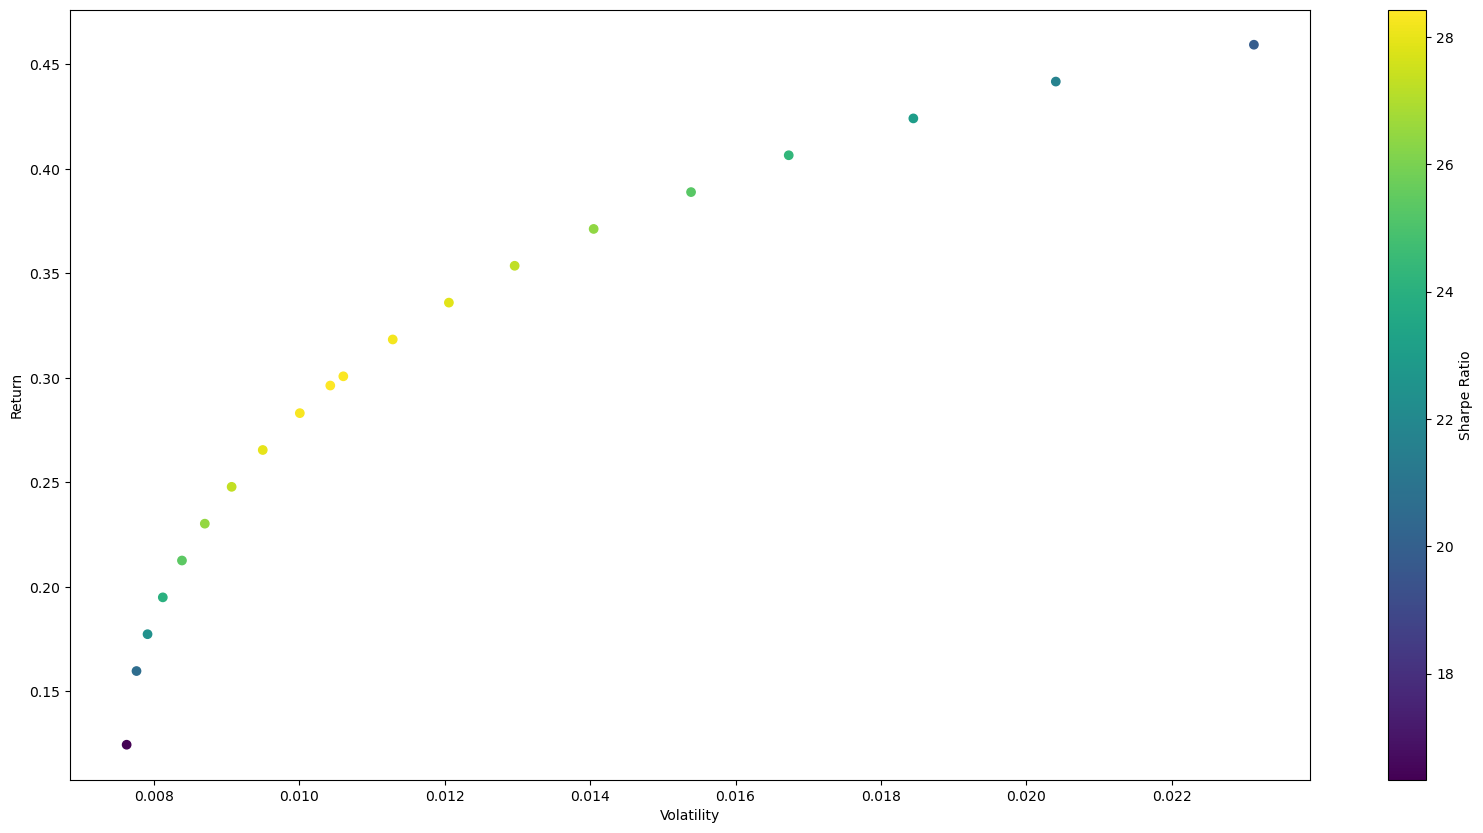

In [41]:
# plot the Efficient Frontier
plt.figure(figsize=(20, 10))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')

plt.show()

The line is curved as expected -  the higher rate of return, the higher volatility.

## <a name='conclusions'></a>Conclusions

* The analysis emphasizes the importance of diversification in a portfolio to mitigate risk and potentially enhance returns.
* Investors must carefully balance risk and return, understanding that higher returns often come with increased risk.
* Utilizing quantitative methods such as portfolio optimization can help investors identify the most efficient allocation of assets based on their risk preferences and investment goals. 
* However, investment strategies should be dynamic and adaptable, requiring continuous monitoring and adjustment based on changing market conditions and portfolio performance.